Formatting data.

In [32]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import itertools

# boolean to choose to run hepatitis vs diabetes
is_hepatitis = False
# empty dataframe, will be set to whichever dataset we're using
data_df = pd.DataFrame()

# FORMAT HEPATITIS DATA
if is_hepatitis:
  if not os.path.isfile('./hepatitis.data'):
    !wget http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data

  names = [
         "Class", "AGE", "SEX", "STEROID", "ANTIVIRALS", "FATIGUE", "MALAISE", 
         "ANOREXIA", "LIVER BIG", "LIVER FIRM", "SPLEEN PALPABLE", "SPIDERS", 
         "ASCITES", "VARICES", "BILIRUBIN", "ALK PHOSPHATE", "SGOT", "ALBUMIN", 
         "PROTIME", "HISTOLOGY"
         ]

  hep_df = pd.read_csv("hepatitis.data", header=None, names=names)
  hep_df = hep_df[(hep_df.ne("?").all(1))].reset_index(drop=True)

  # convert data from str to numbers
  hep_df = hep_df.astype('float', errors='ignore')
  data_df = hep_df

# FORMAT DIABETES DATA
else:
  if not os.path.isfile('./messidor_features.arff'):
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff

  # from https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set
  # info:
  #   column 19: 1 = contains signs of DR, 0 = no signs of DR (diabteic retinopathy)
  dia_file = open("messidor_features.arff", 'r')
  dia_lines = dia_file.readlines()

  # names is currently only used when making decision boundaries
  # when it is added, data_df.iloc[:,19] must be changed
  names = [
         "pre-quality", "pre-screening", "MA1","MA2","MA3","MA4","MA5","MA6","Exudate1","Exudate2","Exudate3","Exudate4","Exudate5","Exudate6","Exudate7","Exudate8","MaculaDist","OpticDics","AMFM","Class"
         ]

  dia_df_list = []
  for line in dia_lines:
    line = line.strip("\n")
    if(line and line[0] != "@"):
      dia_df_row = line.split(',')
      dia_df_list.append(dia_df_row)

  dia_df = pd.DataFrame(dia_df_list)
  dia_df = dia_df.astype('float', errors='ignore')
  dia_df.columns = names
  data_df = dia_df  

data_df=(data_df - data_df.min()) / (data_df.max() - data_df.min())

Splitting training and testing sets with cross validation

In [33]:
# get correlations of data to determine which features to use for knn
np.random.seed(1234)

# cross validation number of sets
num_cv_sets = 5

# separate live/die (y) from features (x)
# x and y are dataframes!
if is_hepatitis:
  x, y = data_df.iloc[:, 1:], data_df['Class']
else:
  x, y = data_df.iloc[:,:19], data_df.iloc[:,19]

# print the feature shape and classes of dataset 
(N,D), C = x.shape, y.nunique()
print(f'instances (N) \t {N} \nfeatures  (D) \t {D} \nclasses   (C) \t {C}')

inds = np.random.permutation(N)

# split the dataset into train and test (x has 80 data points)
if is_hepatitis:
  val_split = 50
else:
  val_split = 1050

x_train, y_train = x.iloc[inds[:val_split],:], y.iloc[inds[:val_split]]
x_test, y_test = x.iloc[inds[val_split:],:], y.iloc[inds[val_split:]]

# change to numpy arrays
x_train = x_train.to_numpy(dtype='float')
y_train = y_train.to_numpy(dtype='int64')
x_test = x_test.to_numpy(dtype='float')
y_test = y_test.to_numpy(dtype='int64')

# print to check
# print(x_train)
# print()
# print(y_train)
# print()
# print(x_test)
# print()
# print(y_test)

instances (N) 	 1151 
features  (D) 	 19 
classes   (C) 	 2


KNN Class.

In [34]:
# distances measurements
# if the input shapes are [1,N1,F] and [N2,1,F] then output shape is [N2,N1]
# as numpy supports broadcasting with arithmetic operations
# for more on numpy broadcasting refer to: https://numpy.org/doc/stable/user/basics.broadcasting.html   
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:

  def __init__(self, K=1, dist_fn = euclidean):
    self.dist_fn = dist_fn
    self.K = K
    return
  
  def fit(self, x, y):
    '''Store the training data using this method since KNN is a lazy learner'''
    self.x = x
    self.y = y
    self.C = np.size(np.unique(y)) + 1
    return self
  
  def predict(self, x_test):
    '''Makes a prediction using the stored training data and the test data given as argument'''
    num_test = x_test.shape[0]

    # calculate distance between training & test samples and returns an array of shape [num_test, num_train]?? TODO: update this comment
    distances = self.dist_fn(self.x[:,None,:], x_test[None,:,:])
    # print(np.shape(distances))

    # i-th row of knns stores the indices of k closest training samples to the i-th test sample
    knns = np.zeros((num_test, self.K), dtype=int)

    # i-th row of y_prob has probability distribution over C classes
    y_prob = np.zeros((num_test, self.C))
    for i in range(num_test):
      knns[i,:] = np.argsort(distances[:,i])[:self.K]  # CHECK THIS, but I think it's right now
      y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
    #y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
    #simply divide by K to get a probability distribution
    y_prob /= self.K

    return y_prob, knns
  

Sweep through different values of K and check accuracy.

In [35]:
# #boolean array to later slice the indexes of correct and incorrect predictions
# correct = y_test == y_pred
# incorrect = np.logical_not(correct)

# quick and dirty check for which k is best without doing cross validation
def sweep_k(x_train, x_test):
  
  accuracies = []
  # max value of k values to check accuracy
  max_k = 0
  if is_hepatitis:
    max_k = 25
  else:
    max_k = 100

  for i in range(1,max_k):
    model = KNN(K=i, dist_fn=euclidean)
    y_prob, knns = model.fit(x_train[:,1:], y_train).predict(x_test[:,1:])

    y_pred = np.argmax(y_prob, axis=-1)
    # print(y_pred)
    # print(y_test)
    # print()
    accuracy = np.sum(y_pred == y_test)/ y_test.shape[0]
    accuracies.append(accuracy)

  max_accuracy = max(accuracies)
  k_max_accuracy = accuracies.index(max_accuracy) + 1

  return max_accuracy, k_max_accuracy

  # visualization of accuracy vs k
  # fig, (ax1) = plt.subplots(1, 1)
  # ax1.plot(np.arange(max_k-1), np.array(accuracies) * 100)
  # ax1.set_xlabel('k')


Determining which features are important by removing a single feature (column) at a time and checking the accuracy.

In [36]:
accuracies_k = []

if is_hepatitis:
  print("Testing hepatitis dataset by dropping one column:")
else:
  print("Testing diabetes dataset by dropping one column: ")

# drop one feature and check accuracy
for i in range(x_train.shape[1]):
  x_train_i = np.delete(x_train, i, 1) # delete a column
  x_test_i = np.delete(x_test, i, 1)

  max_accuracy, k = sweep_k(x_train_i, x_test_i)
  accuracies_k.append((max_accuracy, k))
  print("\tdropping column #%d\tmax accuracy = %.5f\t k = %d" % (i, max_accuracy, k))

# get average accuracy
av_accuracy = 0
for (accuracy, k) in accuracies_k:
  av_accuracy += accuracy
av_accuracy /= len(accuracies_k)
print("average accuracy: %f" % av_accuracy)


Testing diabetes dataset by dropping one column: 
	dropping column #0	max accuracy = 0.65347	 k = 29
	dropping column #1	max accuracy = 0.65347	 k = 29
	dropping column #2	max accuracy = 0.65347	 k = 29
	dropping column #3	max accuracy = 0.65347	 k = 29
	dropping column #4	max accuracy = 0.65347	 k = 33
	dropping column #5	max accuracy = 0.65347	 k = 29
	dropping column #6	max accuracy = 0.66337	 k = 31
	dropping column #7	max accuracy = 0.68317	 k = 31
	dropping column #8	max accuracy = 0.67327	 k = 25
	dropping column #9	max accuracy = 0.66337	 k = 27
	dropping column #10	max accuracy = 0.65347	 k = 1
	dropping column #11	max accuracy = 0.67327	 k = 31
	dropping column #12	max accuracy = 0.67327	 k = 31
	dropping column #13	max accuracy = 0.67327	 k = 31
	dropping column #14	max accuracy = 0.67327	 k = 31
	dropping column #15	max accuracy = 0.67327	 k = 31
	dropping column #16	max accuracy = 0.65347	 k = 1
	dropping column #17	max accuracy = 0.64356	 k = 1
	dropping column #18	max ac

Dropping all features which had little impact on accuracy. These are the features where accuracy did not decrease significantly when the feature was removed.

In [38]:
# pick above average accuracies and drop those columns
num_dropped = 0
indices_drop = []
for i in range(len(accuracies_k)):
  accuracy, index = accuracies_k[i]
  
  if accuracy > av_accuracy:
    indices_drop.append(i)
    num_dropped += 1
print("dropping columns: " + str(indices_drop))
# now run model and check accuracy

x_train_best_features = np.delete(x_train, indices_drop, 1)
x_test_best_features = np.delete(x_test, indices_drop, 1)

a, i = sweep_k(x_train_best_features, x_test_best_features)
print('highest ' + str(a*100) + ' with ' + str(num_dropped) + ' dropped columns for k = ' + str(i))

dropping columns: [7, 8, 11, 12, 13, 14, 15, 18]
highest 67.32673267326733 with 8 dropped columns for k = 18


Examine effect of scaling features.

In [20]:
accuracies_k = []

if is_hepatitis:
  print("Testing hepatitis dataset by up-scaling one column:")
else:
  print("Testing diabetes dataset by up-scaling one column: ")

scale_factor = 20

# magnify one feature and check accuracy
for i in range(x_train_best_features.shape[1]):
  x_train_i = x_train_best_features
  x_test_i = x_test_best_features
  
  x_train_i[:,i] *= scale_factor
  x_test_i[:,i] *= scale_factor

  max_accuracy, k = sweep_k(x_train_i, x_test_i)
  accuracies_k.append((max_accuracy, k))
  print("scaling column #%d\tmax accuracy = %.5f\t k = %d" % (i, max_accuracy, k))

# get average accuracy
av_accuracy = 0
for (accuracy, k) in accuracies_k:
  av_accuracy += accuracy
av_accuracy /= len(accuracies_k)
print("average accuracy: %f" % av_accuracy)

Testing hepatitis dataset by up-scaling one column:
scaling column #0	max accuracy = 0.86667	 k = 3
scaling column #1	max accuracy = 0.86667	 k = 3
scaling column #2	max accuracy = 0.90000	 k = 3
scaling column #3	max accuracy = 0.90000	 k = 3
scaling column #4	max accuracy = 0.86667	 k = 3
scaling column #5	max accuracy = 0.86667	 k = 2
scaling column #6	max accuracy = 0.86667	 k = 1
scaling column #7	max accuracy = 0.83333	 k = 1
scaling column #8	max accuracy = 0.86667	 k = 3
scaling column #9	max accuracy = 0.90000	 k = 4
scaling column #10	max accuracy = 0.86667	 k = 3
scaling column #11	max accuracy = 0.86667	 k = 3
average accuracy: 0.872222


Now put it all together...


In [21]:
x_train_i = x_train_best_features
x_test_i = x_test_best_features

max_accuracy, k = sweep_k(x_train_i, x_test_i)
print('accuracy = ' + str(a*100) + ' with ' + str(num_dropped) + ' dropped columns for k = ' + str(k))

accuracy = 86.66666666666667 with 7 dropped columns for k = 3


Running Full Cross-Validation to Optimize K

In [22]:
def sweep_k_CV(train, valid):
  if is_hepatitis:
    x_train_CV, y_train_CV = train.iloc[:, 1:], train['Class']
    x_valid_CV, y_valid_CV = valid.iloc[:, 1:], valid['Class']
  else:
    x_train_CV, y_train_CV = train.iloc[:,:19], train.iloc[:,19]
    x_valid_CV, y_valid_CV = valid.iloc[:,:19], valid.iloc[:,19]

  # change to numpy arrays
  x_train_CV = x_train_CV.to_numpy(dtype='float')
  y_train_CV = y_train_CV.to_numpy(dtype='int64')
  x_valid_CV = x_valid_CV.to_numpy(dtype='float')
  y_valid_CV = y_valid_CV.to_numpy(dtype='int64')

  accuracies = []
  # max value of k values to check accuracy
  max_k = 0
  if is_hepatitis:
    max_k = 25
  else:
    max_k = 100

  for i in range(1, max_k):
    model = KNN(K=i, dist_fn=euclidean)
    y_prob_CV, knns = model.fit(x_train_CV[:,1:], y_train_CV).predict(x_valid_CV[:,1:])

    y_pred_CV = np.argmax(y_prob_CV, axis=-1)
    # print(y_pred)
    # print(y_test)
    # print()
    accuracy = np.sum(y_pred_CV == y_valid_CV)/ y_valid_CV.shape[0]
    accuracies.append(accuracy)

  return accuracies

def sweep_dist_CV(train, valid):
  if is_hepatitis:
    x_train_CV, y_train_CV = train.iloc[:, 1:], train['Class']
    x_valid_CV, y_valid_CV = valid.iloc[:, 1:], valid['Class']
  else:
    x_train_CV, y_train_CV = train.iloc[:,:19], train.iloc[:,19]
    x_valid_CV, y_valid_CV = valid.iloc[:,:19], valid.iloc[:,19]

  # change to numpy arrays
  x_train_CV = x_train_CV.to_numpy(dtype='float')
  y_train_CV = y_train_CV.to_numpy(dtype='int64')
  x_valid_CV = x_valid_CV.to_numpy(dtype='float')
  y_valid_CV = y_valid_CV.to_numpy(dtype='int64')

  accuracies = []
  # max value of k values to check accuracy
  distances = [euclidean, manhattan]
  if is_hepatitis: #############################################################################
    k = 7
  else:
    k = 22

  for i in distances:
    model = KNN(K=k, dist_fn=i)
    y_prob_CV, knns = model.fit(x_train_CV[:,1:], y_train_CV).predict(x_valid_CV[:,1:])

    y_pred_CV = np.argmax(y_prob_CV, axis=-1)
    # print(y_pred)
    # print(y_test)
    # print()
    accuracy = np.sum(y_pred_CV == y_valid_CV)/ y_valid_CV.shape[0]
    accuracies.append(accuracy)

  return accuracies

def split_dataframe(dataframe, L):
  dataframes_list = []
  split_interval = int(dataframe.shape[0] / L)
  for i in range(L):
    dataframes_list.append(dataframe.iloc[i*split_interval:(i+1)*split_interval, :])
  return dataframes_list

def get_training_validation_testing(dataframe, L):
  training_sets = []
  validation_sets = []
  # testing_set = split_dataframe(dataframe, L)[L-1]

  for i in range(L):
    split_dataframe_list = split_dataframe(dataframe, L)
    validation_sets.append(split_dataframe_list[i])
    temp_list = []
    for j in range(L):
      if(i != j):
        temp_list.append(split_dataframe_list[j])
    training_sets.append(pd.concat(temp_list))

  return training_sets, validation_sets
  # return training_sets, validation_sets, testing_set

def cross_validation(dataframe, L):
  split = 0
  if is_hepatitis:
    split = 30
  else:
    split = 275
  np.random.seed(1234)
  inds = np.random.permutation(data_df.shape[0])

  # training_sets, validation_sets, test_set = get_training_validation_testing(dataframe, L)
  training_sets, validation_sets = get_training_validation_testing(dataframe.iloc[inds[split:]], L)
  test_set = dataframe.iloc[inds[:split]]
  all_accuracies = []
  distance_accuracies = []
  for i in range(len(training_sets)):
    all_accuracies.append(sweep_k_CV(training_sets[i], validation_sets[i]))

  for i in range(len(training_sets)):
    distance_accuracies.append(sweep_dist_CV(training_sets[i], validation_sets[i]))
  average_dist_accuracies = np.divide(np.sum(np.array(distance_accuracies), 0), len(distance_accuracies))
  
  print("distance accuracies:")
  print(average_dist_accuracies)
  print()
  
  average_accuracies = np.divide(np.sum(np.array(all_accuracies), 0), len(all_accuracies))
  print("average accuracies per K")
  print(average_accuracies)
  max_CV_accuracy = np.amax(average_accuracies)
  k_max_CV_accuracy = np.where(average_accuracies == max_CV_accuracy)[0] + 1

  print("max validation accuracy = %.5f\t k = %d\n" % (max_CV_accuracy, k_max_CV_accuracy[0]))
  return k_max_CV_accuracy[0], pd.concat([training_sets[0], validation_sets[0]]), test_set

best_k_CV, train_CV, test_CV = cross_validation(data_df, 10)
if is_hepatitis:
  x_train_CV, y_train_CV = train_CV.iloc[:, 1:], train_CV['Class']
  x_test_CV, y_test_CV = test_CV.iloc[:, 1:], test_CV['Class']
else:
  x_train_CV, y_train_CV = train_CV.iloc[:,:19], train_CV.iloc[:,19]
  x_test_CV, y_test_CV = test_CV.iloc[:,:19], test_CV.iloc[:,19]

# change to numpy arrays
x_train_CV = x_train_CV.to_numpy(dtype='float')
y_train_CV = y_train_CV.to_numpy(dtype='int64')
x_test_CV = x_test_CV.to_numpy(dtype='float')
y_test_CV = y_test_CV.to_numpy(dtype='int64')

CV_model = KNN(K=best_k_CV, dist_fn=euclidean)
y_prob_CV, knns = CV_model.fit(x_train_CV[:,1:], y_train_CV).predict(x_test_CV[:,1:])

y_pred_CV = np.argmax(y_prob_CV, axis=-1)
test_accuracy = np.sum(y_pred_CV == y_test_CV)/ y_test_CV.shape[0]

tp, tn, fp, fn = 0, 0, 0, 0
for i in range(len(y_pred_CV)):
  if(y_pred_CV[i] == 1 and y_test_CV[i] == 1):
    tp += 1
  elif(y_pred_CV[i] == 0 and y_test_CV[i] == 0):
    tn += 1
  elif(y_pred_CV[i] == 0 and y_test_CV[i] == 1):
    fp += 1
  elif(y_pred_CV[i] == 1 and y_test_CV[i] == 0):
    fn += 1
  else:
    pass

confusion_matrix = np.array([
                             [tp, fn],
                             [fp, tn]
                            ])
print(confusion_matrix)
print(np.sum(confusion_matrix))

print("testing accuracy = %.5f" % (test_accuracy))


  

distance accuracies:
[0.88 0.88]

average accuracies per K
[0.88 0.84 0.84 0.84 0.82 0.82 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88
 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88]
max validation accuracy = 0.88000	 k = 7

[[22  6]
 [ 1  1]]
30
testing accuracy = 0.76667


Decision Boundary

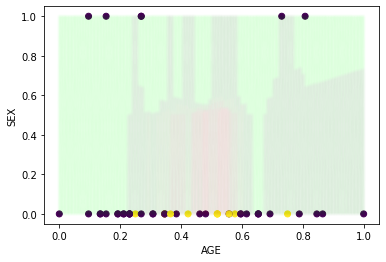

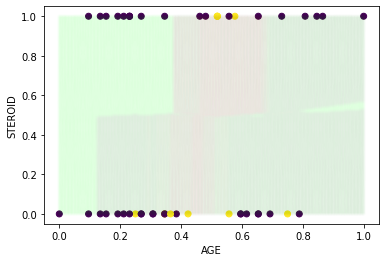

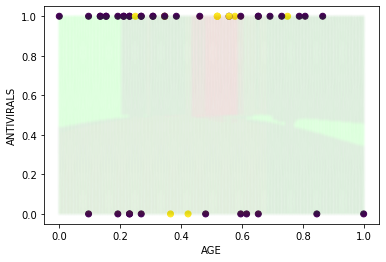

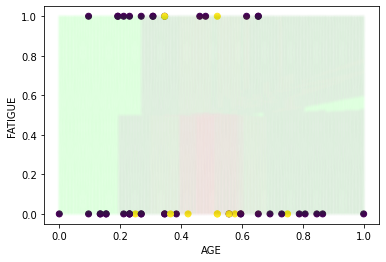

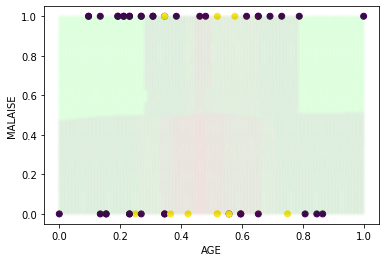

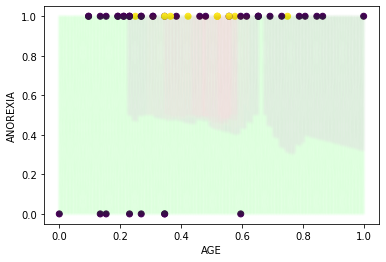

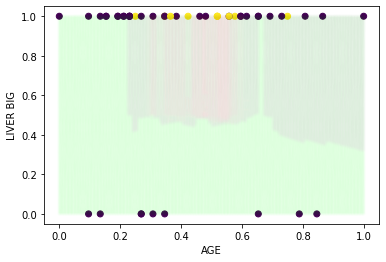

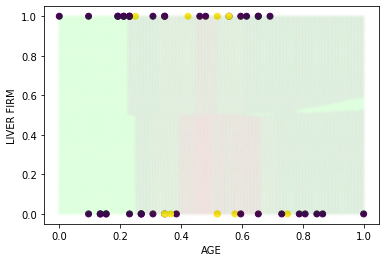

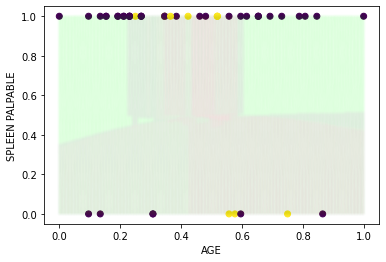

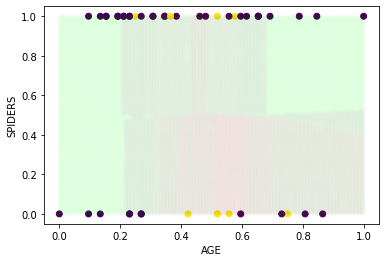

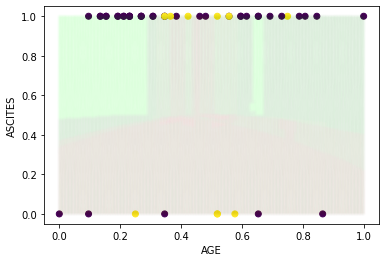

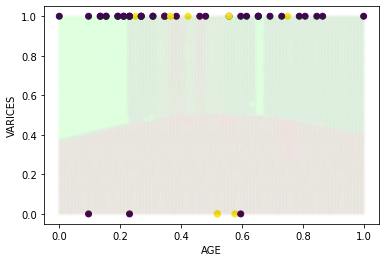

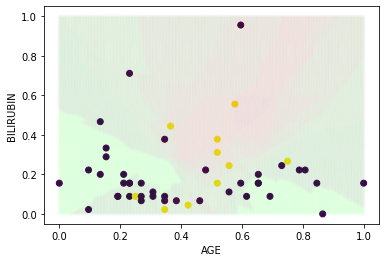

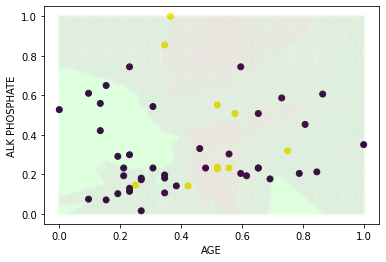

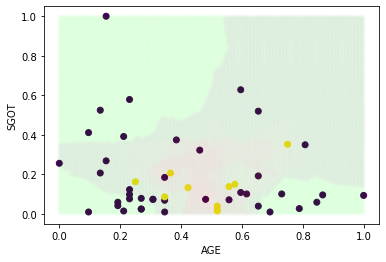

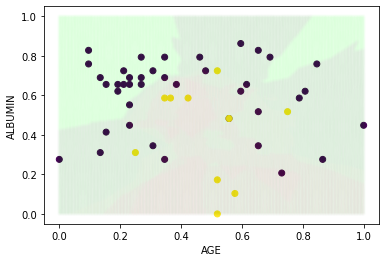

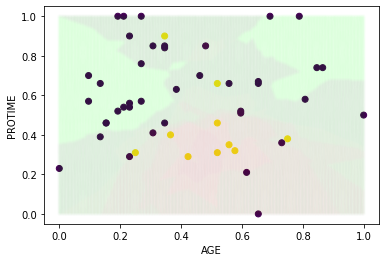

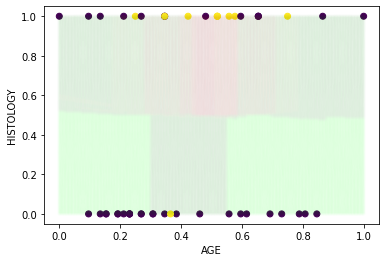

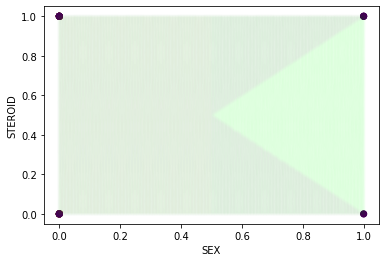

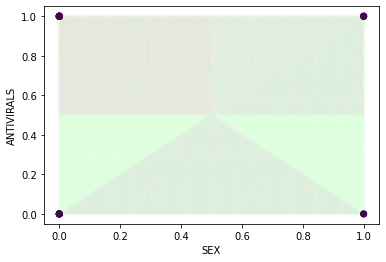

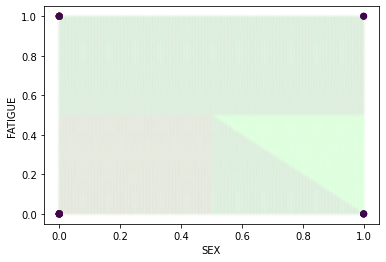

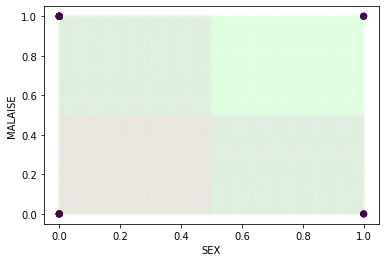

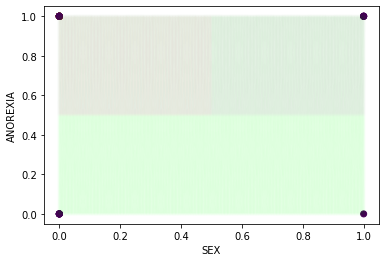

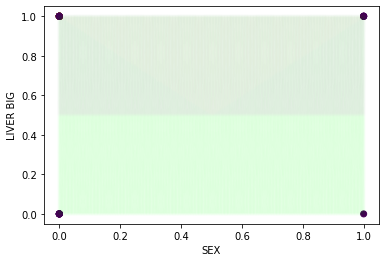

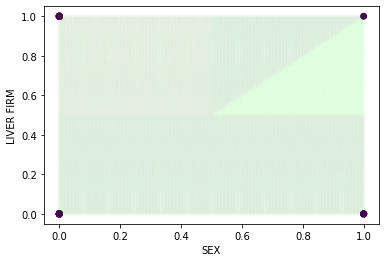

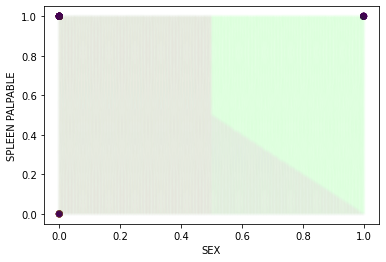

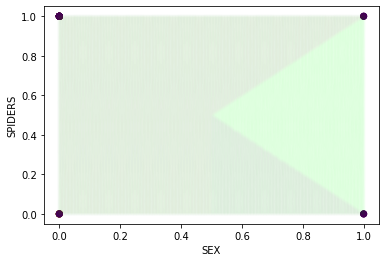

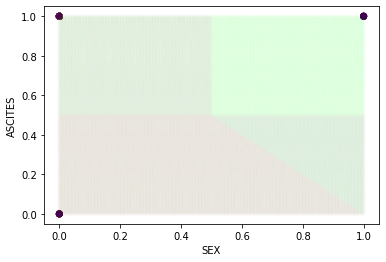

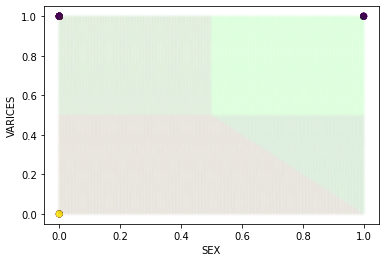

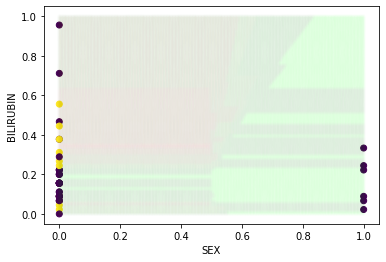

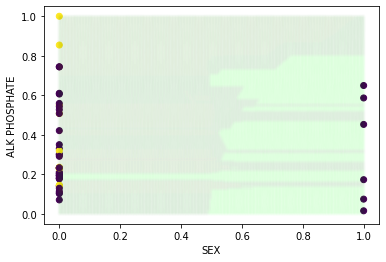

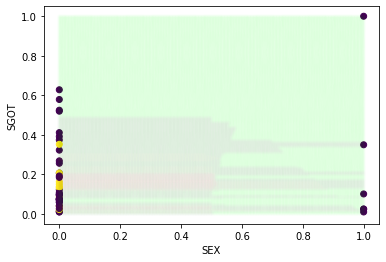

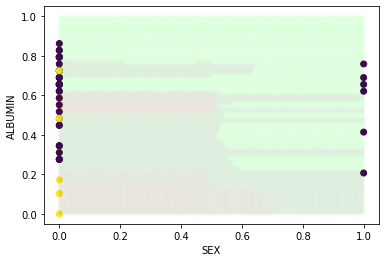

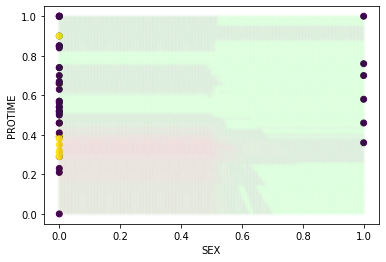

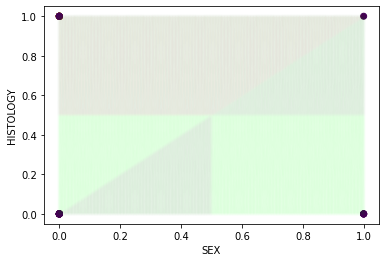

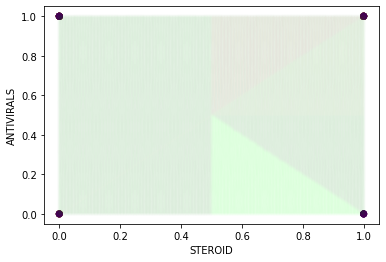

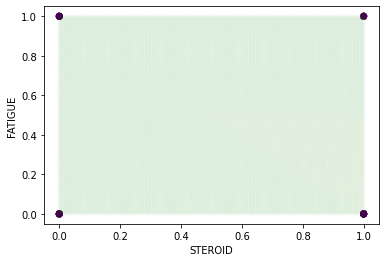

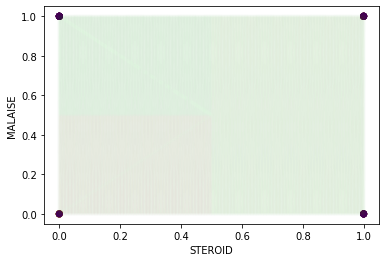

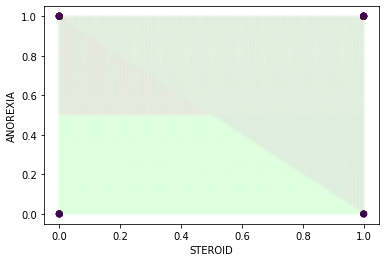

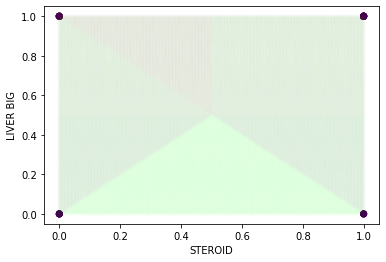

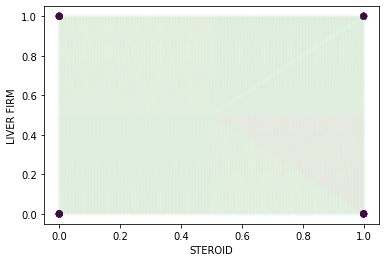

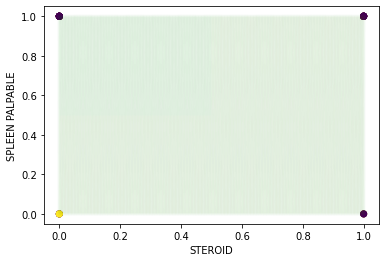

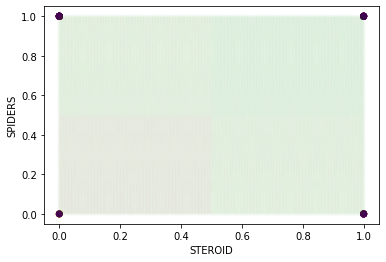

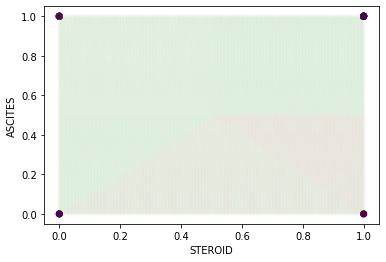

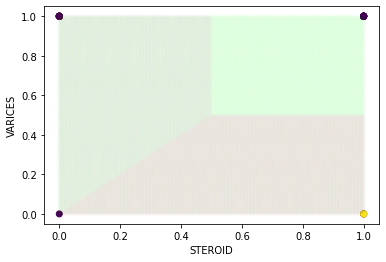

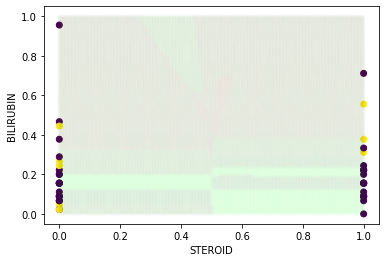

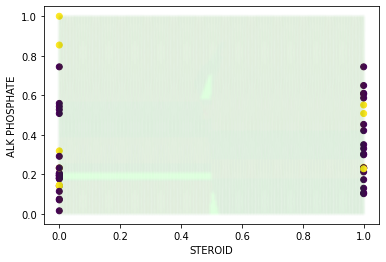

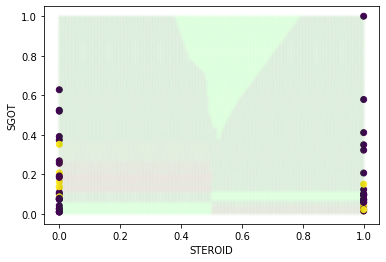

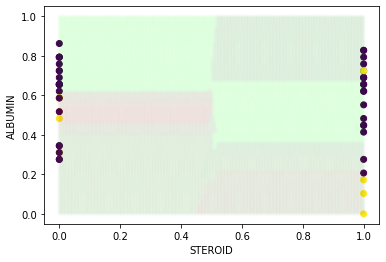

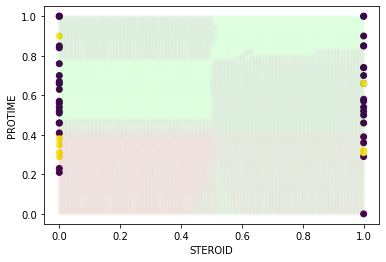

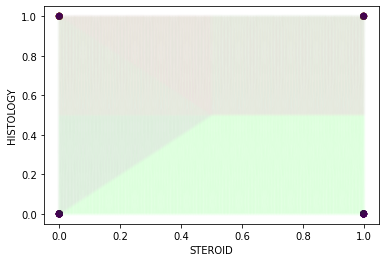

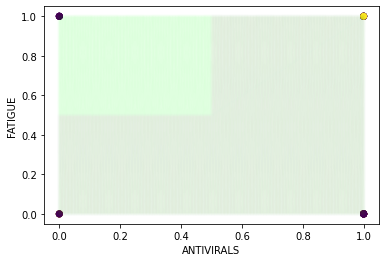

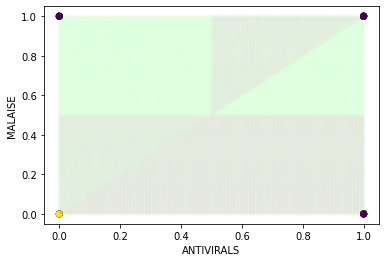

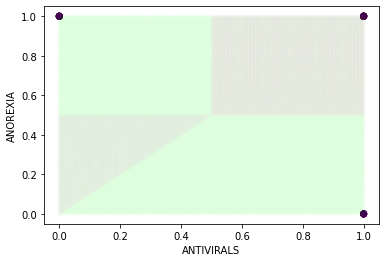

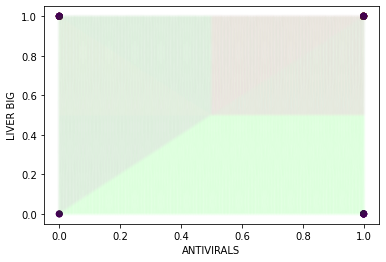

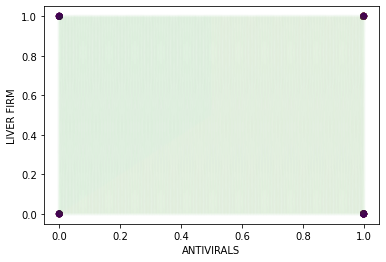

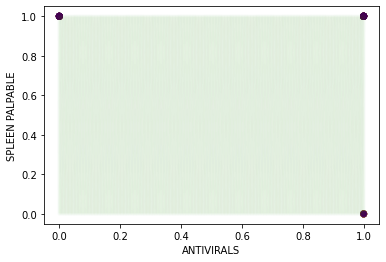

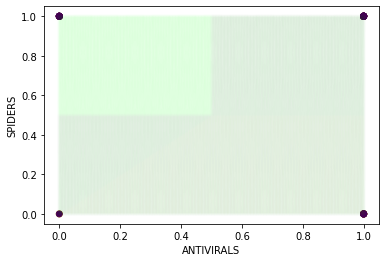

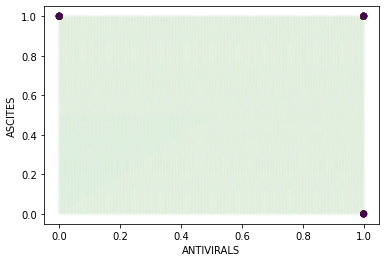

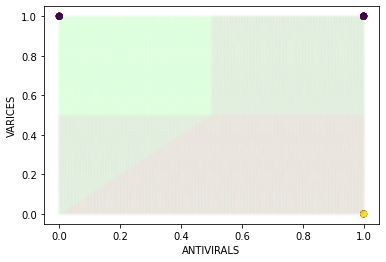

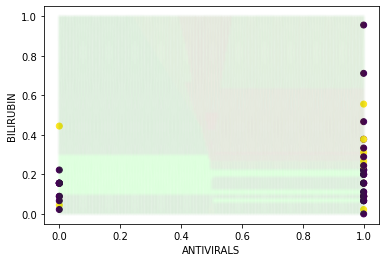

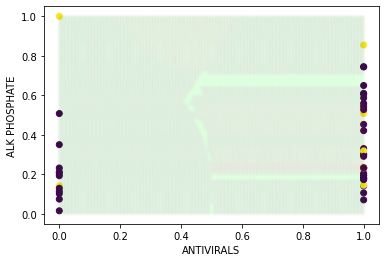

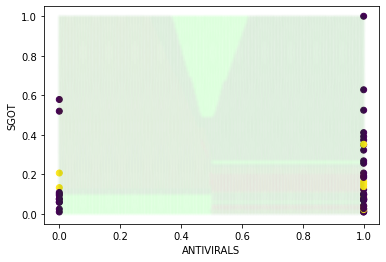

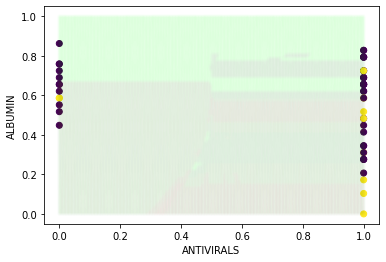

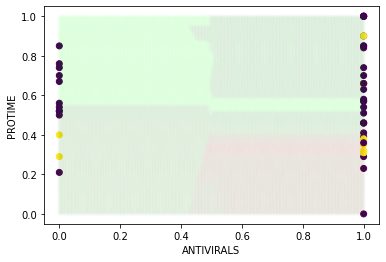

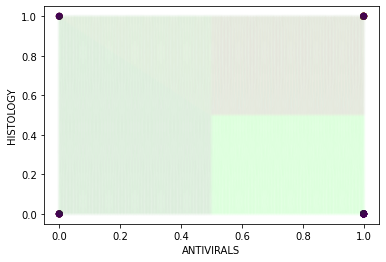

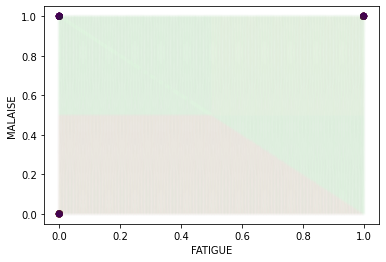

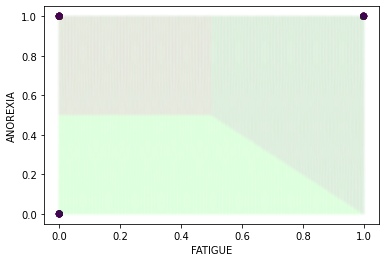

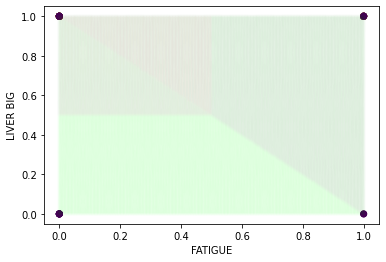

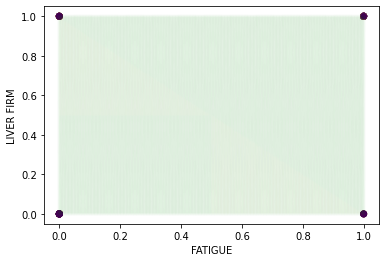

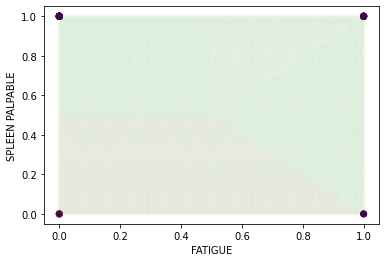

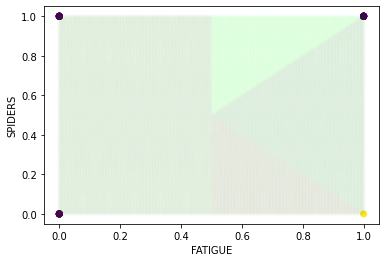

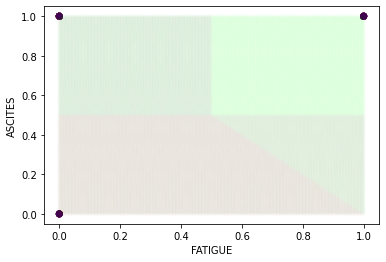

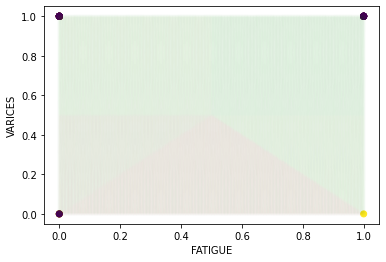

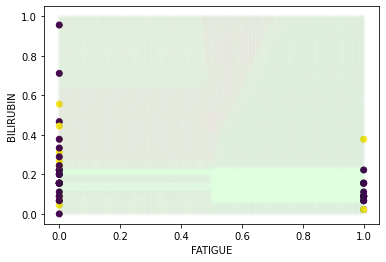

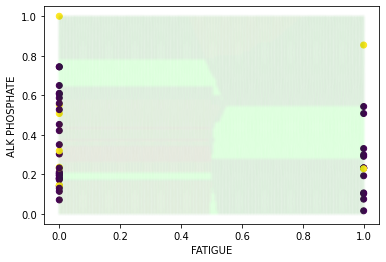

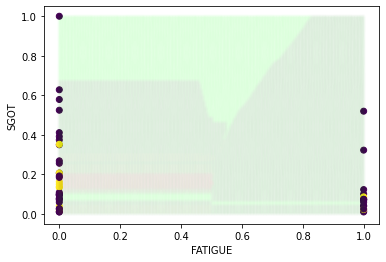

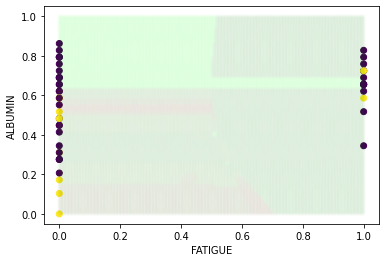

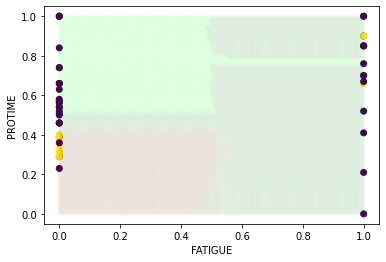

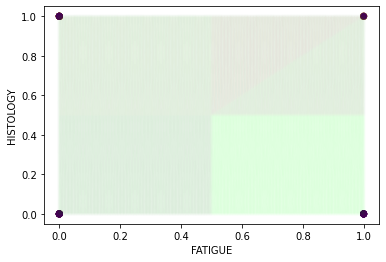

KeyboardInterrupt: ignored

In [23]:
features = list(data_df)[1:]

#Convert output to list 
if is_hepatitis:
  data_groundtruth = np.array(data_df['Class'].tolist()).astype(int)
  data_feat = data_df.drop(['Class'], axis=1)
  data_feat = np.array(data_feat.values.tolist())
  (num_instances, num_features), num_classes = data_feat.shape, np.max(data_groundtruth) + 1
  combolist = [*range(num_features)]
  combolist = list(itertools.combinations(combolist, 2))

  inds = np.random.permutation(num_instances)
  for combo in combolist:
    f1, f2 = combo
    x, y = data_feat.astype(float)[:,[f1,f2]], data_groundtruth

    #train-test split
    x_train, y_train = x[inds[:50]], y[inds[:50]]
    x_test, y_test = x[inds[50:]], y[inds[50:]]

    x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
    x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
    x0,x1 = np.meshgrid(x0v, x1v)
    x_all = np.vstack((x0.ravel(),x1.ravel())).T

    model = KNN(K=7, dist_fn=euclidean)
    y_train_prob = np.zeros((y_train.shape[0], num_classes))
    y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
    y_prob_all = model.fit(x_train, y_train).predict(x_all)
    plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob[:,0], marker='o', alpha=1)
    plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all[0], marker='.', alpha=.01)
    plt.ylabel(features[f2])
    plt.xlabel(features[f1])
    plt.show()

else:
  data_groundtruth = np.array(data_df.iloc[:,19].tolist()).astype(int)
  data_feat = data_df.drop(data_df.iloc[:,19], axis=1)
  # data_groundtruth = np.array(data_df['Class'].tolist()).astype(int)
  # data_feat = data_df.drop(['Class'], axis=1)
  data_feat = np.array(data_feat.values.tolist())
  (num_instances, num_features), num_classes = data_feat.shape, np.max(data_groundtruth) + 1
  combolist = [(3,5),(2,4)]

  for combo in combolist:
    f1, f2 = combo
    x, y = data_feat.astype(float)[:,[f1,f2]], data_groundtruth

    #train-test split
    x_train, y_train = x[inds[:800]], y[inds[:800]]
    x_test, y_test = x[inds[800:]], y[inds[800:]]

    x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
    x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
    x0,x1 = np.meshgrid(x0v, x1v)
    x_all = np.vstack((x0.ravel(),x1.ravel())).T


    model = KNN(K=20)
    y_train_prob = np.zeros((y_train.shape[0], num_classes))
    y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
    y_prob_all = model.fit(x_train, y_train).predict(x_all)
  
    plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob[:, 0], marker='o', alpha=1)
    plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all[0], marker='.', alpha=.01)
    plt.ylabel(features[f2-1])
    plt.xlabel(features[f1-1])
    plt.show()